# Demo of optimisation-based reconstruction in CIL

### The case is a 3D parallel-beam synchrotron dataset of a steel wire.

First we import everything we need:

In [1]:
# Import all CIL components needed
from cil.framework import ImageData, ImageGeometry
from cil.framework import AcquisitionGeometry, AcquisitionData
from cil.framework import BlockDataContainer

from cil.optimisation.algorithms import CGLS, GD, FISTA, PDHG
from cil.optimisation.operators import BlockOperator, GradientOperator, IdentityOperator, \
                                       GradientOperator, FiniteDifferenceOperator
from cil.optimisation.functions import IndicatorBox, MixedL21Norm, L2NormSquared, \
                                       BlockFunction, L1Norm, LeastSquares, \
                                       OperatorCompositionFunction, TotalVariation, \
                                       ZeroFunction

# CIL Processors
from cil.processors import CentreOfRotationCorrector, Slicer, TransmissionAbsorptionConverter

from cil.utilities.display import show2D

# Import from cil.plugins.astra
from cil.plugins.astra.processors import FBP, AstraBackProjector3D
from cil.plugins.astra.operators import ProjectionOperator, AstraProjector3DSimple

# All external imports
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import scipy

Exactly as in the introductory CIL demo from week 1, we load the steel-wire demonstration data provided as part of CIL, carry out some preprocessing and FBP reconstructions for reference:

Centre of rotation correction using cross-correlation
	Calculated from slice:  centre
	Applied centre of rotation shift =  6.37 pixels at the detector.


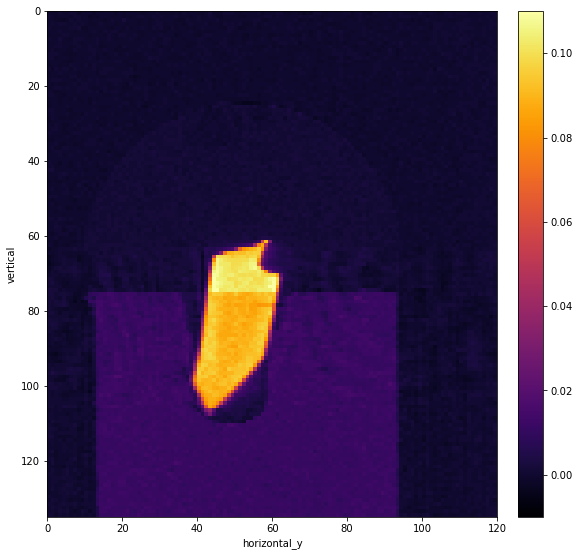

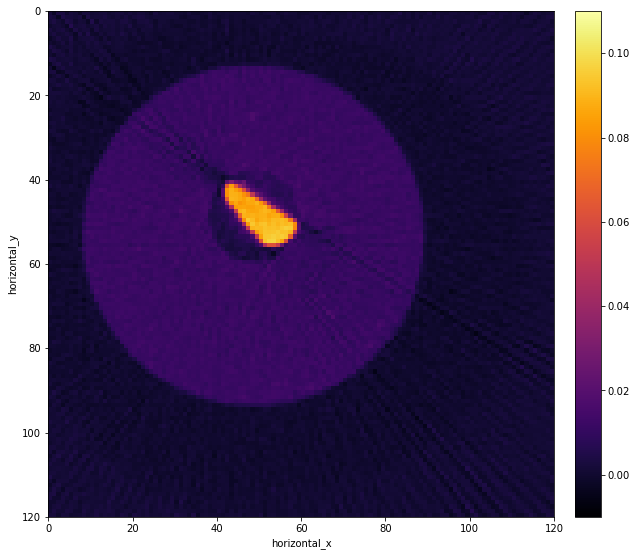

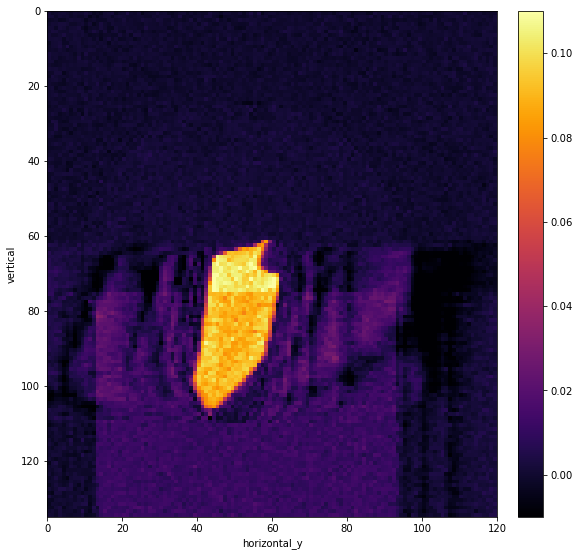

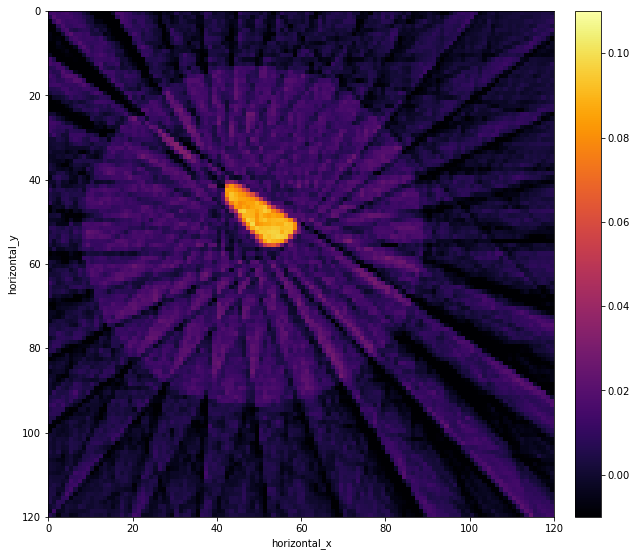

In [2]:
from cil.utilities.dataexample import SYNCHROTRON_PARALLEL_BEAM_DATA
data_sync = SYNCHROTRON_PARALLEL_BEAM_DATA.get()

scale = data_sync.get_slice(vertical=20).mean()
data_sync = data_sync/scale

data_sync = TransmissionAbsorptionConverter()(data_sync)

data_sync = CentreOfRotationCorrector.xcorrelation(slice_index='centre')(data_sync)

data90 = Slicer(roi={'angle':(0,90), 
                     'horizontal':(20,140,1)})(data_sync)

data90.reorder(order='astra')

ag90 = data90.geometry
ig = ag90.get_ImageGeometry()

recon90 = FBP(ig, ag90, device='gpu')(data90)

sx = 44
sz = 103
ca1 = -0.01
ca2 =  0.11

show2D(recon90.get_slice(horizontal_x=sx), cmap='inferno', fix_range=(ca1,ca2), origin='upper-left')
show2D(recon90.get_slice(vertical=sz)   , cmap='inferno', fix_range=(ca1,ca2), origin='upper-left')

data15 = Slicer(roi={'angle': (0,90,6)})(data90)

ag = data15.geometry

recon15 = FBP(ig, ag, device='gpu')(data15)

show2D(recon15.get_slice(horizontal_x=sx), cmap='inferno', fix_range=(ca1,ca2), origin='upper-left')
show2D(recon15.get_slice(vertical=sz)   , cmap='inferno', fix_range=(ca1,ca2), origin='upper-left')

The first thing we are going to need is the LinearOperator representing forward and back-projections. We set up the ProjectionOperator from the CIL-ASTRA plugin by passing the 15-projection image and acquisition geometries:

In [3]:
A = ProjectionOperator(ig, ag)

In iterative algorithms we must provide an initial point from which to start, here we choose the zero image. We further use `b` to refer to the dataset:

In [4]:
x0 = ig.allocate(0.0)
b = data15

CGLS setting up
CGLS configured
     Iter   Max Iter     Time/Iter            Objective
                               [s]                     
        0       1000         0.000          8.11749e+04
        1       1000         0.060          1.67888e+04
        2       1000         0.054          3.51453e+03
-------------------------------------------------------
        2       1000         0.054          3.51453e+03
Stop criterion has been reached.



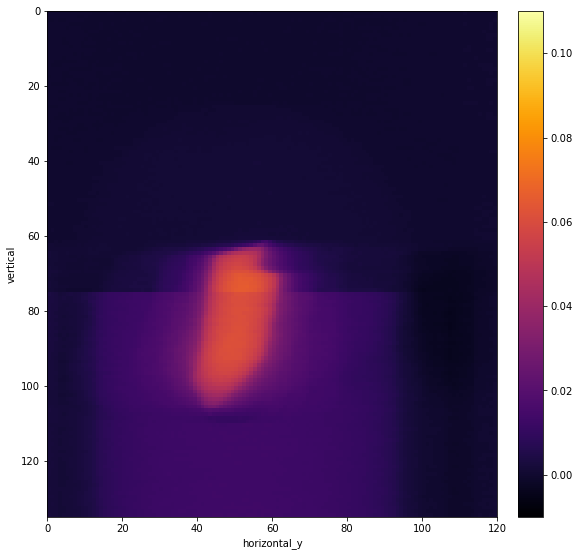

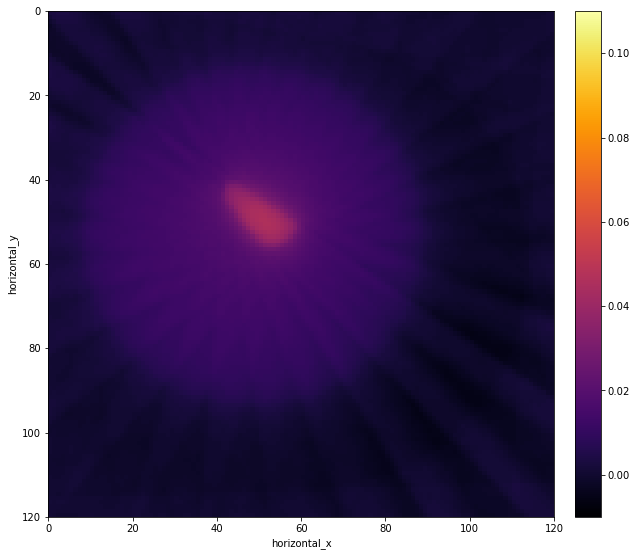

In [5]:
myCGLS = CGLS(x_init=x0, operator=A, data=b, max_iteration=1000)

myCGLS.run(2,verbose=True)

show2D(myCGLS.solution.get_slice(horizontal_x=sx), cmap='inferno', fix_range=(ca1,ca2), origin='upper-left')
show2D(myCGLS.solution.get_slice(vertical=sz)    , cmap='inferno', fix_range=(ca1,ca2), origin='upper-left')

     Iter   Max Iter     Time/Iter            Objective
                               [s]                     
        2       1000         0.054          3.51453e+03
        3       1000         0.049          1.13017e+03
        4       1000         0.046          1.71267e+02
        5       1000         0.045          3.68648e+01
        6       1000         0.044          2.60843e+01
        7       1000         0.043          1.16842e+01
        8       1000         0.043          7.70993e+00
        9       1000         0.044          6.52567e+00
       10       1000         0.044          5.95368e+00
       11       1000         0.044          5.55439e+00
       12       1000         0.043          5.05755e+00
       13       1000         0.044          4.63169e+00
       14       1000         0.045          4.48641e+00
       15       1000         0.044          4.21921e+00
       16       1000         0.044          3.90601e+00
       17       1000         0.043          3.75

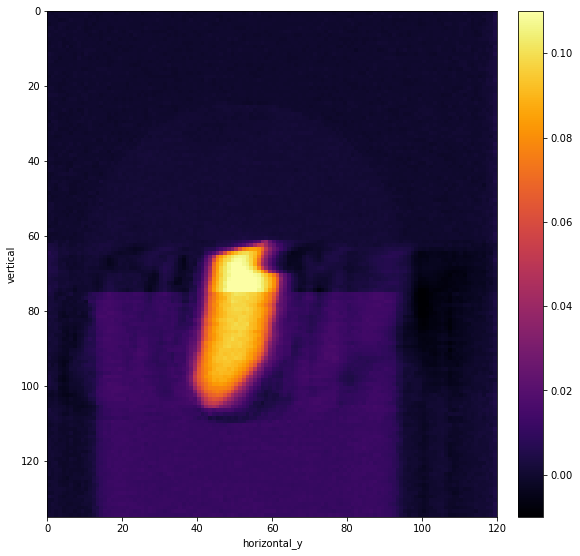

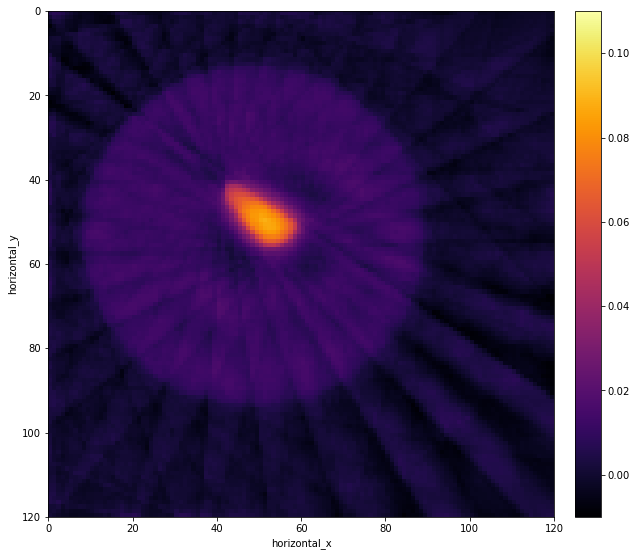

In [6]:
myCGLS.run(18,verbose=1)

show2D(myCGLS.solution.get_slice(horizontal_x=sx),cmap='inferno',fix_range=(ca1,ca2),origin='upper-left')
show2D(myCGLS.solution.get_slice(vertical=sz),cmap='inferno',fix_range=(ca1,ca2),origin='upper-left')

     Iter   Max Iter     Time/Iter            Objective
                               [s]                     
       20       1000         0.047          3.28010e+00
       21       1000         0.047          3.18489e+00
       22       1000         0.046          3.14245e+00
       23       1000         0.045          3.06220e+00
       24       1000         0.045          2.99354e+00
       25       1000         0.045          2.93541e+00
       26       1000         0.046          2.91535e+00
       27       1000         0.046          2.83614e+00
       28       1000         0.045          2.79021e+00
       29       1000         0.044          2.75964e+00
       30       1000         0.044          2.71101e+00
       31       1000         0.044          2.66658e+00
       32       1000         0.044          2.63688e+00
       33       1000         0.044          2.62462e+00
       34       1000         0.045          2.58456e+00
       35       1000         0.045          2.55

      167       1000         0.040          1.64338e+00
      168       1000         0.040          1.64101e+00
      169       1000         0.040          1.63917e+00
      170       1000         0.040          1.63616e+00
      171       1000         0.040          1.63543e+00
      172       1000         0.040          1.63202e+00
      173       1000         0.040          1.62962e+00
      174       1000         0.040          1.62856e+00
      175       1000         0.040          1.62622e+00
      176       1000         0.040          1.62393e+00
      177       1000         0.040          1.62156e+00
      178       1000         0.040          1.62021e+00
      179       1000         0.040          1.61709e+00
      180       1000         0.039          1.61286e+00
      181       1000         0.039          1.61179e+00
      182       1000         0.039          1.60942e+00
      183       1000         0.039          1.60644e+00
      184       1000         0.039          1.60

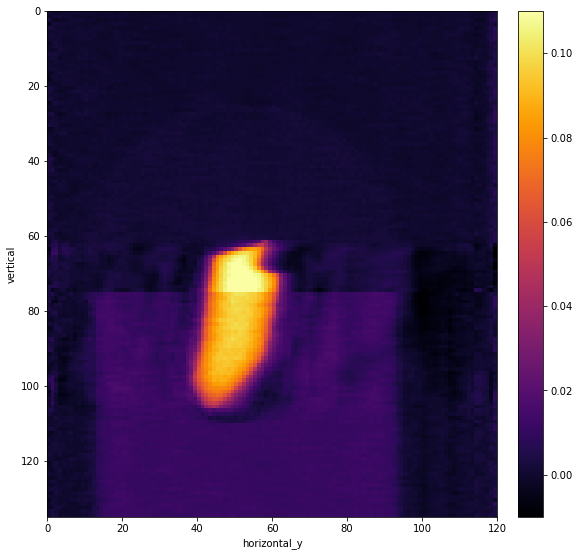

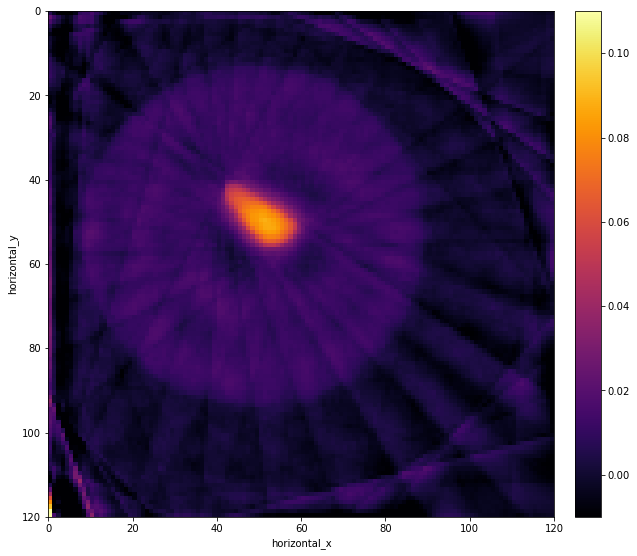

In [7]:
myCGLS.run(180,verbose=True)

show2D(myCGLS.solution.get_slice(horizontal_x=sx),cmap='inferno',fix_range=(ca1,ca2),origin='upper-left')
show2D(myCGLS.solution.get_slice(vertical=sz),cmap='inferno',fix_range=(ca1,ca2),origin='upper-left')

     Iter   Max Iter     Time/Iter            Objective
                               [s]                     
      200       1000         0.039          1.56755e+00
      201       1000         0.039          1.56525e+00
      202       1000         0.039          1.56403e+00
      203       1000         0.039          1.56170e+00
      204       1000         0.039          1.55937e+00
      205       1000         0.039          1.55776e+00
      206       1000         0.039          1.55653e+00
      207       1000         0.039          1.55352e+00
      208       1000         0.039          1.55137e+00
      209       1000         0.039          1.55030e+00
      210       1000         0.039          1.54830e+00
      211       1000         0.039          1.54614e+00
      212       1000         0.039          1.54422e+00
      213       1000         0.039          1.54302e+00
      214       1000         0.039          1.53905e+00
      215       1000         0.039          1.53

      347       1000         0.039          1.32039e+00
      348       1000         0.039          1.31960e+00
      349       1000         0.039          1.31831e+00
      350       1000         0.039          1.31667e+00
      351       1000         0.039          1.31480e+00
      352       1000         0.039          1.31406e+00
      353       1000         0.039          1.31187e+00
      354       1000         0.039          1.31035e+00
      355       1000         0.039          1.30968e+00
      356       1000         0.038          1.30838e+00
      357       1000         0.038          1.30691e+00
      358       1000         0.038          1.30555e+00
      359       1000         0.038          1.30480e+00
      360       1000         0.038          1.30293e+00
      361       1000         0.039          1.30190e+00
      362       1000         0.039          1.30101e+00
      363       1000         0.039          1.29963e+00
      364       1000         0.039          1.29

      497       1000         0.037          1.14729e+00
      498       1000         0.037          1.14589e+00
      499       1000         0.037          1.14529e+00
      500       1000         0.037          1.14394e+00
      501       1000         0.037          1.14261e+00
      502       1000         0.037          1.14210e+00
      503       1000         0.037          1.14124e+00
      504       1000         0.037          1.14043e+00
      505       1000         0.037          1.13964e+00
      506       1000         0.037          1.13922e+00
      507       1000         0.037          1.13815e+00
      508       1000         0.037          1.13712e+00
      509       1000         0.037          1.13655e+00
      510       1000         0.037          1.13567e+00
      511       1000         0.037          1.13429e+00
      512       1000         0.037          1.13354e+00
      513       1000         0.037          1.13214e+00
      514       1000         0.037          1.13

      644       1000         0.036          1.02608e+00
      645       1000         0.036          1.02583e+00
      646       1000         0.036          1.02513e+00
      647       1000         0.036          1.02444e+00
      648       1000         0.036          1.02400e+00
      649       1000         0.036          1.02341e+00
      650       1000         0.036          1.02241e+00
      651       1000         0.036          1.02190e+00
      652       1000         0.036          1.02110e+00
      653       1000         0.036          1.02043e+00
      654       1000         0.036          1.01968e+00
      655       1000         0.036          1.01934e+00
      656       1000         0.036          1.01846e+00
      657       1000         0.036          1.01766e+00
      658       1000         0.036          1.01734e+00
      659       1000         0.036          1.01648e+00
      660       1000         0.036          1.01591e+00
      661       1000         0.036          1.01

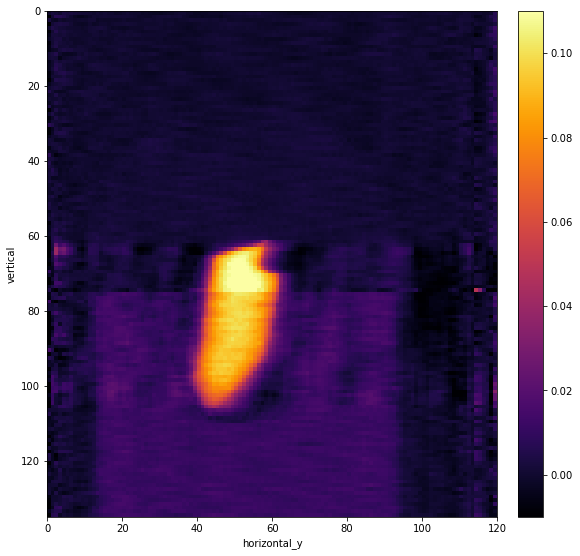

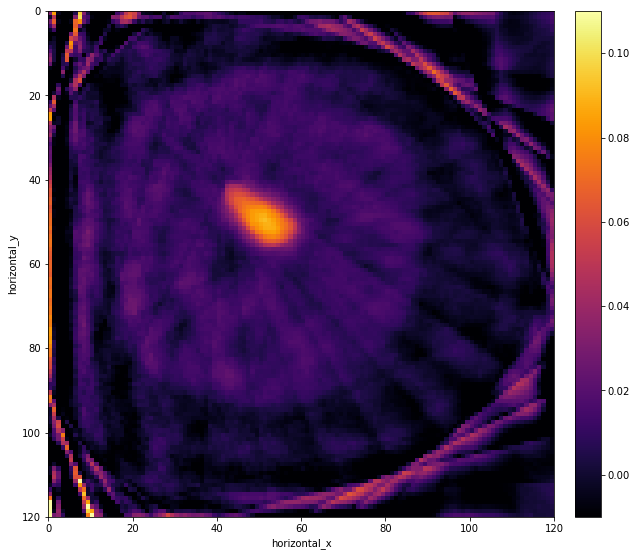

In [8]:
myCGLS.run(500,verbose=True)
show2D(myCGLS.solution.get_slice(horizontal_x=sx),cmap='inferno',fix_range=(ca1,ca2),origin='upper-left')
show2D(myCGLS.solution.get_slice(vertical=sz),cmap='inferno',fix_range=(ca1,ca2),origin='upper-left')

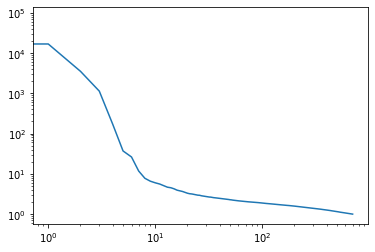

In [9]:
plt.loglog(myCGLS.objective)

In [10]:
f1 = 0.5*LeastSquares(A, b)

myGD_LS = GD(x_init=x0, objective_function=f1, step_size=None, max_iteration=100000, update_objective_interval = 10)
myGD_LS.run(3000, verbose=1)

GD setting up
GD configured
     Iter   Max Iter     Time/Iter            Objective
                               [s]                     
        0     100000         0.000          4.05874e+04
       10     100000         0.079          1.07271e+03
       20     100000         0.060          2.60185e+02
       30     100000         0.053          8.07507e+01
       40     100000         0.050          2.96652e+01
       50     100000         0.048          1.31531e+01
       60     100000         0.047          7.20265e+00
       70     100000         0.046          4.81435e+00
       80     100000         0.045          3.74216e+00
       90     100000         0.045          3.20141e+00
      100     100000         0.044          2.89505e+00
      110     100000         0.044          2.70160e+00
      120     100000         0.044          2.56741e+00
      130     100000         0.043          2.46703e+00
      140     100000         0.043          2.38744e+00
      150     100000

     1440     100000         0.042          1.27834e+00
     1450     100000         0.042          1.27684e+00
     1460     100000         0.042          1.27535e+00
     1470     100000         0.042          1.27387e+00
     1480     100000         0.042          1.27241e+00
     1490     100000         0.043          1.27096e+00
     1500     100000         0.043          1.26953e+00
     1510     100000         0.043          1.26811e+00
     1520     100000         0.043          1.26671e+00
     1530     100000         0.043          1.26532e+00
     1540     100000         0.043          1.26394e+00
     1550     100000         0.043          1.26257e+00
     1560     100000         0.043          1.26122e+00
     1570     100000         0.043          1.25988e+00
     1580     100000         0.043          1.25855e+00
     1590     100000         0.043          1.25723e+00
     1600     100000         0.043          1.25593e+00
     1610     100000         0.043          1.25

     2910     100000         0.045          1.14376e+00
     2920     100000         0.045          1.14317e+00
     2930     100000         0.045          1.14259e+00
     2940     100000         0.045          1.14200e+00
     2950     100000         0.045          1.14142e+00
     2960     100000         0.045          1.14085e+00
     2970     100000         0.045          1.14027e+00
     2980     100000         0.045          1.13970e+00
     2990     100000         0.045          1.13913e+00
     3000     100000         0.045          1.13856e+00
-------------------------------------------------------
     3000     100000         0.045          1.13856e+00
Stop criterion has been reached.



701

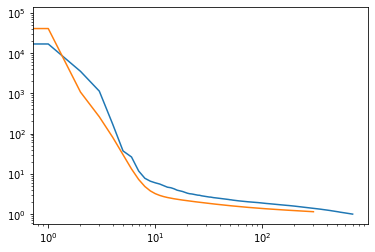

In [41]:
plt.loglog(myCGLS.iterations, myCGLS.objective)
plt.loglog(myGD_LS.objective)
len(myCGLS.objective)

In [12]:
f1 = LeastSquares(A, b)

D = GradientOperator(ig)
alpha = 1.0
f2 = OperatorCompositionFunction(L2NormSquared(),D)
f = f1 + (alpha**2)*f2

myGD = GD(x_init=x0, objective_function=f, step_size=None, max_iteration=1000, update_objective_interval = 10)
myGD.run(1000, verbose=1)

Initialised GradientOperator with C backend running with  20  threads
GD setting up
GD configured
     Iter   Max Iter     Time/Iter            Objective
                               [s]                     
        0       1000         0.000          8.11749e+04
       10       1000         0.131          2.14862e+03
       20       1000         0.102          5.26598e+02
       30       1000         0.092          1.69574e+02
       40       1000         0.087          6.84620e+01
       50       1000         0.083          3.60537e+01
       60       1000         0.082          2.45235e+01
       70       1000         0.081          1.99790e+01
       80       1000         0.080          1.79855e+01
       90       1000         0.079          1.70057e+01
      100       1000         0.079          1.64639e+01
      110       1000         0.078          1.61280e+01
      120       1000         0.078          1.58977e+01
      130       1000         0.078          1.57261e+01
      

<Figure size 432x288 with 0 Axes>

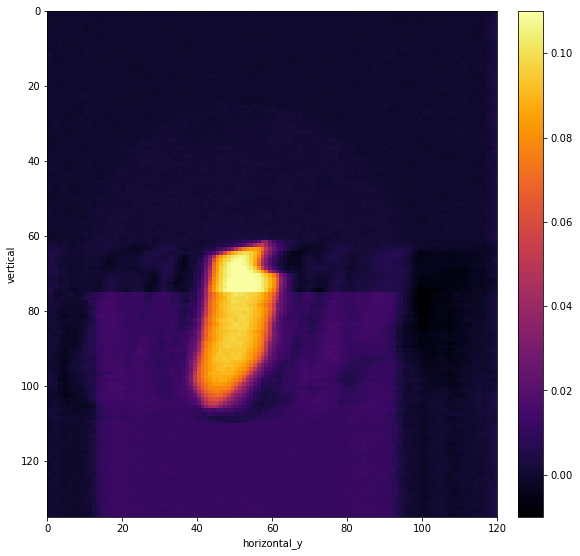

<Figure size 432x288 with 0 Axes>

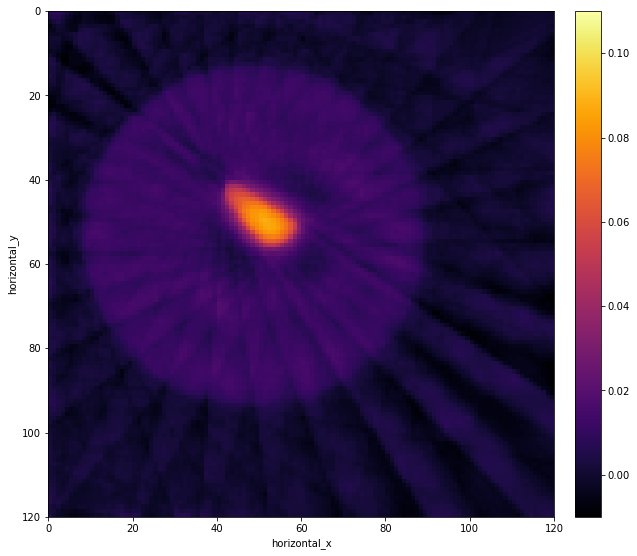

In [13]:
plt.figure()
show2D(myGD.solution.get_slice(horizontal_x=sx),cmap='inferno',fix_range=(ca1,ca2),origin='upper-left')
plt.figure()
show2D(myGD.solution.get_slice(vertical=sz),cmap='inferno',fix_range=(ca1,ca2),origin='upper-left')

In [14]:
F = LeastSquares(A, b)
G = IndicatorBox(lower=0.0)
myFISTANN = FISTA(f=F, g=G, x_init=x0, max_iteration=1000)
myFISTANN.run(300, verbose=1)

FISTA setting up
FISTA configured
     Iter   Max Iter     Time/Iter            Objective
                               [s]                     
        0       1000         0.000          8.11749e+04
        1       1000         0.035          1.71929e+04
        2       1000         0.035          1.12123e+04
        3       1000         0.035          6.94816e+03
        4       1000         0.036          4.28064e+03
        5       1000         0.036          2.69005e+03
        6       1000         0.036          1.72841e+03
        7       1000         0.037          1.12575e+03
        8       1000         0.037          7.38952e+02
        9       1000         0.037          4.90657e+02
       10       1000         0.037          3.34645e+02
       11       1000         0.037          2.39900e+02
       12       1000         0.037          1.84004e+02
       13       1000         0.037          1.50779e+02
       14       1000         0.037          1.29383e+02
       15     

      146       1000         0.038          3.24513e+01
      147       1000         0.038          3.24485e+01
      148       1000         0.038          3.24457e+01
      149       1000         0.038          3.24429e+01
      150       1000         0.038          3.24402e+01
      151       1000         0.038          3.24376e+01
      152       1000         0.038          3.24350e+01
      153       1000         0.038          3.24324e+01
      154       1000         0.038          3.24299e+01
      155       1000         0.038          3.24274e+01
      156       1000         0.038          3.24249e+01
      157       1000         0.038          3.24225e+01
      158       1000         0.038          3.24201e+01
      159       1000         0.038          3.24177e+01
      160       1000         0.038          3.24154e+01
      161       1000         0.038          3.24131e+01
      162       1000         0.038          3.24108e+01
      163       1000         0.038          3.24

      297       1000         0.038          3.22557e+01
      298       1000         0.038          3.22550e+01
      299       1000         0.038          3.22544e+01
      300       1000         0.038          3.22538e+01
-------------------------------------------------------
      300       1000         0.038          3.22538e+01
Stop criterion has been reached.



<Figure size 432x288 with 0 Axes>

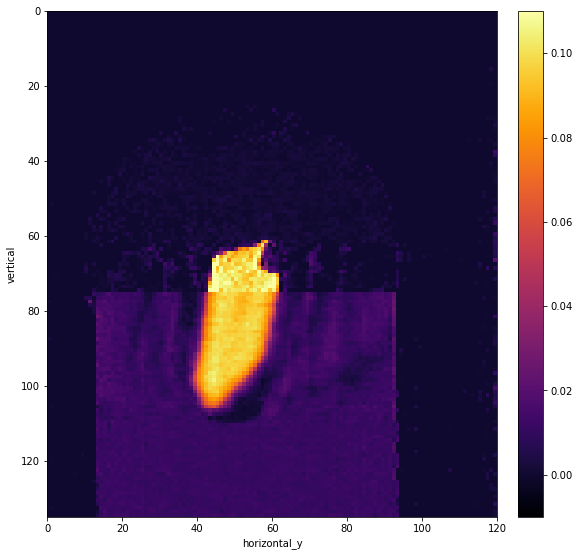

<Figure size 432x288 with 0 Axes>

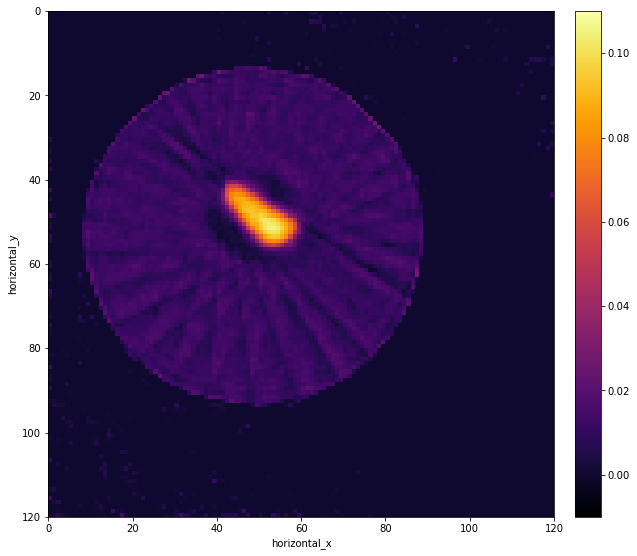

In [15]:
plt.figure()
show2D(myFISTANN.solution.get_slice(horizontal_x=sx),cmap='inferno',fix_range=(ca1,ca2),origin='upper-left')
plt.figure()
show2D(myFISTANN.solution.get_slice(vertical=sz),cmap='inferno',fix_range=(ca1,ca2),origin='upper-left')

In [16]:
a1 = 30
G = a1*L1Norm()

myFISTAL1 = FISTA(f=F, g=G, x_init=x0, max_iteration=1000, update_objective_interval=10)

FISTA setting up
FISTA configured


In [17]:
myFISTAL1.run(300,verbose=1)

     Iter   Max Iter     Time/Iter            Objective
                               [s]                     
        0       1000         0.000          8.11749e+04
       10       1000         0.040          6.89870e+04
       20       1000         0.039          6.88011e+04
       30       1000         0.039          6.87865e+04
       40       1000         0.039          6.87823e+04
       50       1000         0.039          6.87808e+04
       60       1000         0.039          6.87800e+04
       70       1000         0.039          6.87794e+04
       80       1000         0.039          6.87791e+04
       90       1000         0.039          6.87789e+04
      100       1000         0.039          6.87790e+04
      110       1000         0.039          6.87793e+04
      120       1000         0.039          6.87796e+04
      130       1000         0.039          6.87799e+04
      140       1000         0.039          6.87801e+04
      150       1000         0.039          6.87

<Figure size 432x288 with 0 Axes>

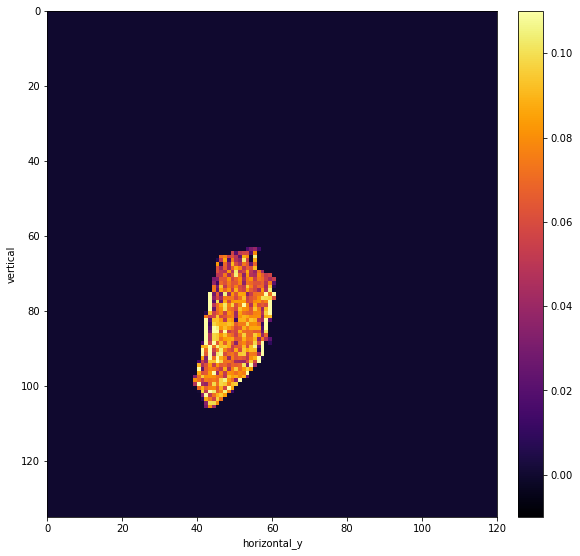

<Figure size 432x288 with 0 Axes>

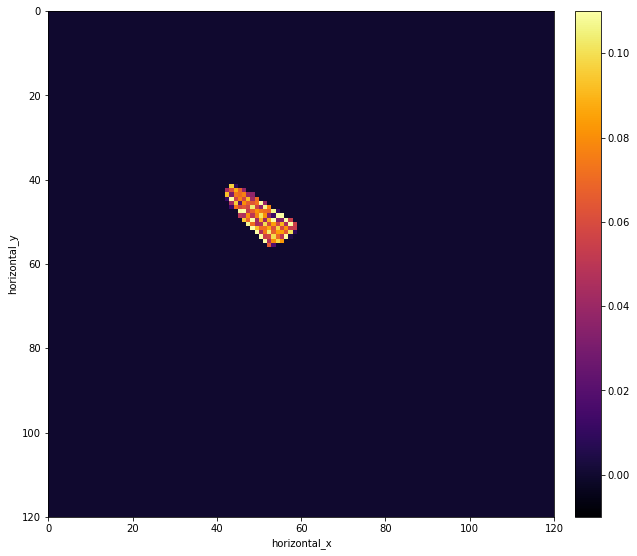

In [18]:
plt.figure()
show2D(myFISTAL1.solution.get_slice(horizontal_x=sx),cmap='inferno',fix_range=(ca1,ca2),origin='upper-left')
plt.figure()
show2D(myFISTAL1.solution.get_slice(vertical=sz),cmap='inferno',fix_range=(ca1,ca2),origin='upper-left')

In [19]:
GTV = 0.02*TotalVariation()

In [20]:
myFISTATV = FISTA(f=F, g=GTV, x_init=x0 ,max_iteration=1000)

FISTA setting up
FISTA configured


In [25]:
myFISTATV.run(200,verbose=1)

     Iter   Max Iter     Time/Iter            Objective
                               [s]                     
        2       1000         5.764          1.12102e+04
        3       1000         5.741          6.92972e+03
        4       1000         5.576          4.19663e+03
        5       1000         5.472          2.55308e+03
        6       1000         5.422          1.57358e+03
        7       1000         5.426          9.71989e+02
        8       1000         5.406          5.89641e+02
        9       1000         5.350          3.47384e+02
       10       1000         5.354          2.02864e+02
       11       1000         5.339          1.26331e+02
       12       1000         5.301          9.27176e+01
       13       1000         5.283          8.19456e+01
       14       1000         5.269          8.04158e+01
       15       1000         5.276          8.07241e+01
       16       1000         5.262          7.98733e+01
       17       1000         5.246          7.72

      147       1000         5.268          3.82043e+01
      148       1000         5.268          3.81710e+01
      149       1000         5.268          3.81389e+01
      150       1000         5.268          3.81079e+01
      151       1000         5.267          3.80781e+01
      152       1000         5.270          3.80494e+01
      153       1000         5.269          3.80219e+01
      154       1000         5.269          3.79956e+01
      155       1000         5.267          3.79705e+01
      156       1000         5.266          3.79465e+01
      157       1000         5.265          3.79237e+01
      158       1000         5.265          3.79020e+01
      159       1000         5.264          3.78815e+01
      160       1000         5.264          3.78621e+01
      161       1000         5.264          3.78437e+01
      162       1000         5.265          3.78265e+01
      163       1000         5.268          3.78103e+01
      164       1000         5.267          3.77

Show the slices of the TV reconstruction by FISTA:

<Figure size 432x288 with 0 Axes>

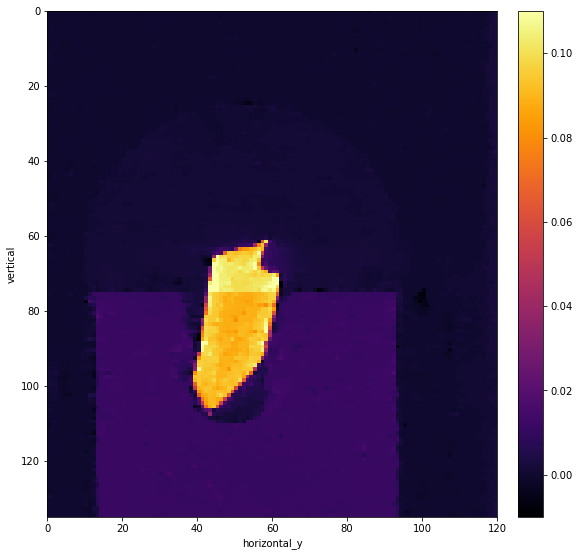

<Figure size 432x288 with 0 Axes>

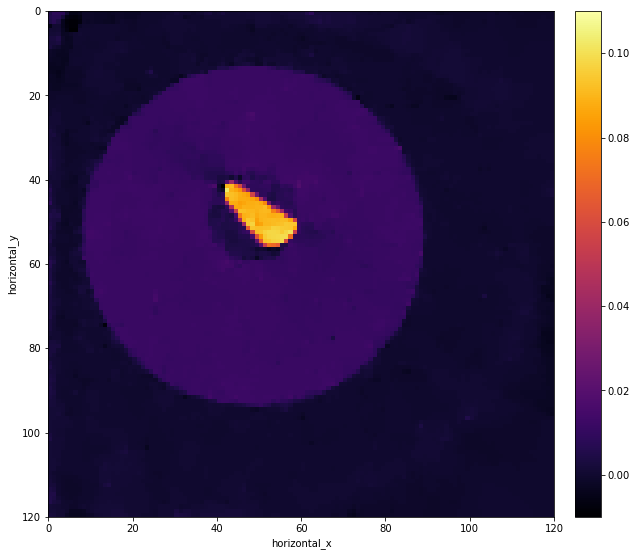

In [26]:
show2D(myFISTATV.solution.get_slice(horizontal_x=sx),cmap='inferno',fix_range=(ca1,ca2),origin='upper-left')
show2D(myFISTATV.solution.get_slice(vertical=sz),cmap='inferno',fix_range=(ca1,ca2),origin='upper-left')

An even more flexible algorithm for non-smooth problems is the Primal Dual Hybrid Gradient (PDHG) algorithm, which also goes under other names such as the Chambolle-Pock algorithm. In PDHG we can split complicated functionals into simpler parts for which the proximal mapping can be evaluated. PDHG will be covered in more detail in a separate notebook, here it is demonstrated how to set up the same TV-regularized problem we just solved with FISTA. Note how BlockFunctions and BlockOperators are used to specify multiple terms/operators:

In [27]:
alpha = 0.02
F = BlockFunction(L2NormSquared(b=b), alpha*MixedL21Norm())
K = BlockOperator(A, D)
G = ZeroFunction()
myPDHG = PDHG(f=F, g=G, operator=K, max_iteration=10000)

Initialised GradientOperator with C backend running with  20  threads
PDHG setting up
PDHG configured


Run the algorithm for a specified number of iterations with increased verbosity/amount of printing to screen:

In [28]:
myPDHG.run(5000,verbose=2)

     Iter   Max Iter     Time/Iter        Primal          Dual     Primal-Dual
                               [s]     Objective     Objective             Gap
        0      10000         0.000    8.11749e+04  -0.00000e+00    8.11749e+04
        1      10000         0.139    8.11749e+04  -0.00000e+00    8.11749e+04
        2      10000         0.135    2.65662e+04  -6.03344e+06    6.06000e+06
        3      10000         0.134    1.33195e+04  -2.00243e+06    2.01575e+06
        4      10000         0.128    7.36950e+03  -1.11609e+06    1.12346e+06
        5      10000         0.126    4.23839e+03  -7.43019e+05    7.47257e+05
        6      10000         0.124    2.59061e+03  -4.97571e+05    5.00162e+05
        7      10000         0.123    1.69115e+03  -3.41480e+05    3.43171e+05
        8      10000         0.122    1.15509e+03  -2.62388e+05    2.63543e+05
        9      10000         0.122    8.05717e+02  -2.22363e+05    2.23168e+05
       10      10000         0.122    5.66660e+02  -

      102      10000         0.131    5.05013e+01  -4.71157e+03    4.76207e+03
      103      10000         0.131    5.04449e+01  -4.68905e+03    4.73949e+03
      104      10000         0.130    5.03893e+01  -4.66618e+03    4.71657e+03
      105      10000         0.130    5.03346e+01  -4.64300e+03    4.69334e+03
      106      10000         0.130    5.02808e+01  -4.61957e+03    4.66985e+03
      107      10000         0.130    5.02278e+01  -4.59594e+03    4.64617e+03
      108      10000         0.130    5.01756e+01  -4.57209e+03    4.62227e+03
      109      10000         0.130    5.01244e+01  -4.54806e+03    4.59819e+03
      110      10000         0.130    5.00739e+01  -4.52387e+03    4.57395e+03
      111      10000         0.130    5.00243e+01  -4.49962e+03    4.54964e+03
      112      10000         0.130    4.99754e+01  -4.47533e+03    4.52531e+03
      113      10000         0.130    4.99273e+01  -4.45107e+03    4.50100e+03
      114      10000         0.130    4.98799e+01  -

      206      10000         0.131    4.69731e+01  -3.00677e+03    3.05374e+03
      207      10000         0.131    4.69498e+01  -2.99604e+03    3.04299e+03
      208      10000         0.131    4.69265e+01  -2.98537e+03    3.03230e+03
      209      10000         0.131    4.69034e+01  -2.97477e+03    3.02167e+03
      210      10000         0.131    4.68804e+01  -2.96423e+03    3.01111e+03
      211      10000         0.131    4.68575e+01  -2.95376e+03    3.00062e+03
      212      10000         0.131    4.68346e+01  -2.94341e+03    2.99025e+03
      213      10000         0.131    4.68119e+01  -2.93320e+03    2.98001e+03
      214      10000         0.131    4.67892e+01  -2.92309e+03    2.96988e+03
      215      10000         0.131    4.67667e+01  -2.91306e+03    2.95982e+03
      216      10000         0.131    4.67441e+01  -2.90311e+03    2.94985e+03
      217      10000         0.131    4.67217e+01  -2.89327e+03    2.94000e+03
      218      10000         0.131    4.66993e+01  -

      310      10000         0.130    4.49615e+01  -2.19880e+03    2.24376e+03
      311      10000         0.130    4.49457e+01  -2.19292e+03    2.23786e+03
      312      10000         0.130    4.49299e+01  -2.18709e+03    2.23202e+03
      313      10000         0.130    4.49141e+01  -2.18128e+03    2.22619e+03
      314      10000         0.130    4.48984e+01  -2.17549e+03    2.22039e+03
      315      10000         0.130    4.48827e+01  -2.16973e+03    2.21461e+03
      316      10000         0.130    4.48671e+01  -2.16402e+03    2.20888e+03
      317      10000         0.130    4.48515e+01  -2.15834e+03    2.20319e+03
      318      10000         0.130    4.48360e+01  -2.15273e+03    2.19757e+03
      319      10000         0.130    4.48206e+01  -2.14715e+03    2.19197e+03
      320      10000         0.130    4.48051e+01  -2.14161e+03    2.18641e+03
      321      10000         0.130    4.47898e+01  -2.13610e+03    2.18089e+03
      322      10000         0.130    4.47745e+01  -

      414      10000         0.131    4.35475e+01  -1.71206e+03    1.75560e+03
      415      10000         0.131    4.35359e+01  -1.70830e+03    1.75183e+03
      416      10000         0.131    4.35243e+01  -1.70455e+03    1.74807e+03
      417      10000         0.131    4.35127e+01  -1.70079e+03    1.74431e+03
      418      10000         0.131    4.35011e+01  -1.69704e+03    1.74054e+03
      419      10000         0.131    4.34896e+01  -1.69330e+03    1.73679e+03
      420      10000         0.131    4.34781e+01  -1.68955e+03    1.73303e+03
      421      10000         0.131    4.34666e+01  -1.68582e+03    1.72929e+03
      422      10000         0.131    4.34552e+01  -1.68208e+03    1.72554e+03
      423      10000         0.131    4.34438e+01  -1.67836e+03    1.72180e+03
      424      10000         0.131    4.34325e+01  -1.67465e+03    1.71808e+03
      425      10000         0.131    4.34211e+01  -1.67096e+03    1.71438e+03
      426      10000         0.131    4.34099e+01  -

      518      10000         0.132    4.24781e+01  -1.38456e+03    1.42704e+03
      519      10000         0.132    4.24690e+01  -1.38193e+03    1.42440e+03
      520      10000         0.132    4.24600e+01  -1.37930e+03    1.42176e+03
      521      10000         0.132    4.24509e+01  -1.37668e+03    1.41913e+03
      522      10000         0.132    4.24419e+01  -1.37406e+03    1.41650e+03
      523      10000         0.132    4.24329e+01  -1.37145e+03    1.41388e+03
      524      10000         0.132    4.24239e+01  -1.36886e+03    1.41128e+03
      525      10000         0.132    4.24150e+01  -1.36627e+03    1.40868e+03
      526      10000         0.132    4.24060e+01  -1.36370e+03    1.40610e+03
      527      10000         0.132    4.23971e+01  -1.36112e+03    1.40352e+03
      528      10000         0.132    4.23882e+01  -1.35855e+03    1.40094e+03
      529      10000         0.132    4.23794e+01  -1.35598e+03    1.39836e+03
      530      10000         0.132    4.23705e+01  -

      622      10000         0.131    4.16278e+01  -1.15117e+03    1.19280e+03
      623      10000         0.131    4.16204e+01  -1.14928e+03    1.19090e+03
      624      10000         0.131    4.16130e+01  -1.14738e+03    1.18900e+03
      625      10000         0.131    4.16057e+01  -1.14550e+03    1.18710e+03
      626      10000         0.131    4.15983e+01  -1.14362e+03    1.18522e+03
      627      10000         0.131    4.15910e+01  -1.14175e+03    1.18334e+03
      628      10000         0.131    4.15837e+01  -1.13988e+03    1.18147e+03
      629      10000         0.131    4.15764e+01  -1.13802e+03    1.17959e+03
      630      10000         0.131    4.15691e+01  -1.13616e+03    1.17773e+03
      631      10000         0.131    4.15619e+01  -1.13430e+03    1.17587e+03
      632      10000         0.131    4.15546e+01  -1.13246e+03    1.17401e+03
      633      10000         0.131    4.15474e+01  -1.13062e+03    1.17217e+03
      634      10000         0.131    4.15402e+01  -

      726      10000         0.130    4.09256e+01  -9.82859e+02    1.02378e+03
      727      10000         0.131    4.09194e+01  -9.81474e+02    1.02239e+03
      728      10000         0.131    4.09133e+01  -9.80095e+02    1.02101e+03
      729      10000         0.131    4.09071e+01  -9.78727e+02    1.01963e+03
      730      10000         0.131    4.09010e+01  -9.77360e+02    1.01826e+03
      731      10000         0.131    4.08949e+01  -9.76002e+02    1.01690e+03
      732      10000         0.131    4.08888e+01  -9.74648e+02    1.01554e+03
      733      10000         0.131    4.08827e+01  -9.73306e+02    1.01419e+03
      734      10000         0.131    4.08766e+01  -9.71966e+02    1.01284e+03
      735      10000         0.131    4.08705e+01  -9.70639e+02    1.01151e+03
      736      10000         0.131    4.08645e+01  -9.69308e+02    1.01017e+03
      737      10000         0.131    4.08584e+01  -9.67978e+02    1.00884e+03
      738      10000         0.131    4.08524e+01  -

      830      10000         0.130    4.03358e+01  -8.58389e+02    8.98725e+02
      831      10000         0.130    4.03306e+01  -8.57347e+02    8.97677e+02
      832      10000         0.130    4.03254e+01  -8.56305e+02    8.96631e+02
      833      10000         0.130    4.03202e+01  -8.55258e+02    8.95578e+02
      834      10000         0.130    4.03151e+01  -8.54219e+02    8.94534e+02
      835      10000         0.130    4.03099e+01  -8.53175e+02    8.93485e+02
      836      10000         0.130    4.03047e+01  -8.52135e+02    8.92440e+02
      837      10000         0.130    4.02996e+01  -8.51097e+02    8.91396e+02
      838      10000         0.130    4.02945e+01  -8.50064e+02    8.90358e+02
      839      10000         0.130    4.02893e+01  -8.49029e+02    8.89318e+02
      840      10000         0.130    4.02842e+01  -8.47999e+02    8.88283e+02
      841      10000         0.130    4.02791e+01  -8.46970e+02    8.87249e+02
      842      10000         0.130    4.02740e+01  -

      934      10000         0.130    3.98386e+01  -7.58668e+02    7.98506e+02
      935      10000         0.130    3.98342e+01  -7.57800e+02    7.97635e+02
      936      10000         0.130    3.98299e+01  -7.56933e+02    7.96763e+02
      937      10000         0.130    3.98255e+01  -7.56071e+02    7.95897e+02
      938      10000         0.130    3.98211e+01  -7.55204e+02    7.95025e+02
      939      10000         0.130    3.98168e+01  -7.54343e+02    7.94160e+02
      940      10000         0.130    3.98124e+01  -7.53478e+02    7.93291e+02
      941      10000         0.130    3.98081e+01  -7.52621e+02    7.92429e+02
      942      10000         0.130    3.98037e+01  -7.51760e+02    7.91563e+02
      943      10000         0.130    3.97994e+01  -7.50907e+02    7.90706e+02
      944      10000         0.130    3.97951e+01  -7.50048e+02    7.89843e+02
      945      10000         0.130    3.97908e+01  -7.49192e+02    7.88983e+02
      946      10000         0.130    3.97865e+01  -

     1038      10000         0.130    3.94188e+01  -6.74077e+02    7.13496e+02
     1039      10000         0.130    3.94151e+01  -6.73322e+02    7.12737e+02
     1040      10000         0.130    3.94114e+01  -6.72563e+02    7.11974e+02
     1041      10000         0.130    3.94077e+01  -6.71810e+02    7.11217e+02
     1042      10000         0.130    3.94041e+01  -6.71057e+02    7.10461e+02
     1043      10000         0.130    3.94004e+01  -6.70302e+02    7.09703e+02
     1044      10000         0.130    3.93967e+01  -6.69546e+02    7.08943e+02
     1045      10000         0.130    3.93931e+01  -6.68794e+02    7.08187e+02
     1046      10000         0.130    3.93894e+01  -6.68044e+02    7.07433e+02
     1047      10000         0.130    3.93858e+01  -6.67291e+02    7.06676e+02
     1048      10000         0.130    3.93821e+01  -6.66542e+02    7.05924e+02
     1049      10000         0.130    3.93785e+01  -6.65793e+02    7.05172e+02
     1050      10000         0.130    3.93749e+01  -

     1143      10000         0.130    3.90610e+01  -6.00171e+02    6.39232e+02
     1144      10000         0.130    3.90579e+01  -5.99513e+02    6.38571e+02
     1145      10000         0.130    3.90548e+01  -5.98860e+02    6.37914e+02
     1146      10000         0.130    3.90517e+01  -5.98206e+02    6.37258e+02
     1147      10000         0.130    3.90486e+01  -5.97554e+02    6.36602e+02
     1148      10000         0.130    3.90455e+01  -5.96899e+02    6.35945e+02
     1149      10000         0.130    3.90424e+01  -5.96242e+02    6.35285e+02
     1150      10000         0.130    3.90393e+01  -5.95591e+02    6.34631e+02
     1151      10000         0.130    3.90362e+01  -5.94935e+02    6.33971e+02
     1152      10000         0.130    3.90331e+01  -5.94278e+02    6.33311e+02
     1153      10000         0.130    3.90300e+01  -5.93629e+02    6.32659e+02
     1154      10000         0.130    3.90270e+01  -5.92975e+02    6.32002e+02
     1155      10000         0.130    3.90239e+01  -

     1247      10000         0.130    3.87624e+01  -5.35680e+02    5.74443e+02
     1248      10000         0.130    3.87598e+01  -5.35098e+02    5.73858e+02
     1249      10000         0.130    3.87572e+01  -5.34515e+02    5.73272e+02
     1250      10000         0.130    3.87545e+01  -5.33934e+02    5.72688e+02
     1251      10000         0.130    3.87519e+01  -5.33352e+02    5.72104e+02
     1252      10000         0.130    3.87493e+01  -5.32770e+02    5.71519e+02
     1253      10000         0.130    3.87467e+01  -5.32186e+02    5.70933e+02
     1254      10000         0.130    3.87441e+01  -5.31609e+02    5.70353e+02
     1255      10000         0.130    3.87415e+01  -5.31031e+02    5.69773e+02
     1256      10000         0.130    3.87389e+01  -5.30452e+02    5.69191e+02
     1257      10000         0.130    3.87363e+01  -5.29873e+02    5.68609e+02
     1258      10000         0.130    3.87338e+01  -5.29299e+02    5.68033e+02
     1259      10000         0.130    3.87312e+01  -

     1351      10000         0.130    3.85120e+01  -4.78267e+02    5.16779e+02
     1352      10000         0.130    3.85098e+01  -4.77742e+02    5.16252e+02
     1353      10000         0.130    3.85076e+01  -4.77212e+02    5.15719e+02
     1354      10000         0.130    3.85054e+01  -4.76680e+02    5.15186e+02
     1355      10000         0.130    3.85032e+01  -4.76156e+02    5.14659e+02
     1356      10000         0.130    3.85010e+01  -4.75634e+02    5.14135e+02
     1357      10000         0.130    3.84989e+01  -4.75107e+02    5.13606e+02
     1358      10000         0.130    3.84967e+01  -4.74588e+02    5.13084e+02
     1359      10000         0.130    3.84945e+01  -4.74065e+02    5.12559e+02
     1360      10000         0.130    3.84924e+01  -4.73541e+02    5.12034e+02
     1361      10000         0.130    3.84902e+01  -4.73019e+02    5.11509e+02
     1362      10000         0.130    3.84880e+01  -4.72498e+02    5.10986e+02
     1363      10000         0.130    3.84859e+01  -

     1455      10000         0.130    3.83034e+01  -4.25907e+02    4.64210e+02
     1456      10000         0.130    3.83016e+01  -4.25422e+02    4.63724e+02
     1457      10000         0.130    3.82998e+01  -4.24940e+02    4.63240e+02
     1458      10000         0.130    3.82980e+01  -4.24458e+02    4.62756e+02
     1459      10000         0.130    3.82962e+01  -4.23978e+02    4.62274e+02
     1460      10000         0.130    3.82944e+01  -4.23500e+02    4.61794e+02
     1461      10000         0.130    3.82925e+01  -4.23017e+02    4.61309e+02
     1462      10000         0.130    3.82907e+01  -4.22542e+02    4.60832e+02
     1463      10000         0.130    3.82889e+01  -4.22066e+02    4.60355e+02
     1464      10000         0.130    3.82871e+01  -4.21588e+02    4.59875e+02
     1465      10000         0.130    3.82853e+01  -4.21115e+02    4.59400e+02
     1466      10000         0.130    3.82836e+01  -4.20643e+02    4.58926e+02
     1467      10000         0.130    3.82818e+01  -

     1559      10000         0.130    3.81305e+01  -3.77805e+02    4.15936e+02
     1560      10000         0.130    3.81290e+01  -3.77363e+02    4.15492e+02
     1561      10000         0.130    3.81275e+01  -3.76915e+02    4.15043e+02
     1562      10000         0.130    3.81260e+01  -3.76468e+02    4.14594e+02
     1563      10000         0.130    3.81245e+01  -3.76019e+02    4.14144e+02
     1564      10000         0.130    3.81230e+01  -3.75573e+02    4.13696e+02
     1565      10000         0.130    3.81215e+01  -3.75125e+02    4.13246e+02
     1566      10000         0.130    3.81200e+01  -3.74677e+02    4.12797e+02
     1567      10000         0.130    3.81186e+01  -3.74232e+02    4.12350e+02
     1568      10000         0.130    3.81171e+01  -3.73785e+02    4.11902e+02
     1569      10000         0.130    3.81156e+01  -3.73337e+02    4.11453e+02
     1570      10000         0.130    3.81141e+01  -3.72891e+02    4.11005e+02
     1571      10000         0.130    3.81126e+01  -

     1663      10000         0.130    3.79884e+01  -3.32944e+02    3.70932e+02
     1664      10000         0.130    3.79872e+01  -3.32525e+02    3.70512e+02
     1665      10000         0.130    3.79859e+01  -3.32109e+02    3.70095e+02
     1666      10000         0.130    3.79847e+01  -3.31690e+02    3.69675e+02
     1667      10000         0.130    3.79835e+01  -3.31276e+02    3.69259e+02
     1668      10000         0.130    3.79823e+01  -3.30861e+02    3.68844e+02
     1669      10000         0.130    3.79811e+01  -3.30441e+02    3.68422e+02
     1670      10000         0.130    3.79798e+01  -3.30032e+02    3.68012e+02
     1671      10000         0.130    3.79786e+01  -3.29616e+02    3.67595e+02
     1672      10000         0.130    3.79774e+01  -3.29201e+02    3.67179e+02
     1673      10000         0.130    3.79762e+01  -3.28783e+02    3.66760e+02
     1674      10000         0.130    3.79750e+01  -3.28371e+02    3.66346e+02
     1675      10000         0.130    3.79738e+01  -

     1767      10000         0.130    3.78732e+01  -2.90916e+02    3.28789e+02
     1768      10000         0.130    3.78722e+01  -2.90522e+02    3.28394e+02
     1769      10000         0.130    3.78712e+01  -2.90132e+02    3.28003e+02
     1770      10000         0.130    3.78702e+01  -2.89743e+02    3.27613e+02
     1771      10000         0.130    3.78692e+01  -2.89349e+02    3.27218e+02
     1772      10000         0.130    3.78682e+01  -2.88960e+02    3.26828e+02
     1773      10000         0.130    3.78673e+01  -2.88572e+02    3.26440e+02
     1774      10000         0.130    3.78663e+01  -2.88181e+02    3.26047e+02
     1775      10000         0.130    3.78653e+01  -2.87791e+02    3.25656e+02
     1776      10000         0.130    3.78643e+01  -2.87402e+02    3.25267e+02
     1777      10000         0.130    3.78634e+01  -2.87015e+02    3.24879e+02
     1778      10000         0.130    3.78624e+01  -2.86626e+02    3.24488e+02
     1779      10000         0.130    3.78614e+01  -

     1871      10000         0.130    3.77808e+01  -2.51580e+02    2.89361e+02
     1872      10000         0.130    3.77801e+01  -2.51215e+02    2.88995e+02
     1873      10000         0.130    3.77793e+01  -2.50851e+02    2.88630e+02
     1874      10000         0.130    3.77785e+01  -2.50486e+02    2.88265e+02
     1875      10000         0.130    3.77777e+01  -2.50125e+02    2.87902e+02
     1876      10000         0.130    3.77769e+01  -2.49761e+02    2.87538e+02
     1877      10000         0.130    3.77761e+01  -2.49399e+02    2.87176e+02
     1878      10000         0.130    3.77754e+01  -2.49041e+02    2.86816e+02
     1879      10000         0.130    3.77746e+01  -2.48677e+02    2.86452e+02
     1880      10000         0.130    3.77738e+01  -2.48314e+02    2.86087e+02
     1881      10000         0.130    3.77730e+01  -2.47957e+02    2.85730e+02
     1882      10000         0.130    3.77723e+01  -2.47595e+02    2.85367e+02
     1883      10000         0.130    3.77715e+01  -

     1975      10000         0.130    3.77078e+01  -2.15099e+02    2.52807e+02
     1976      10000         0.130    3.77072e+01  -2.14759e+02    2.52466e+02
     1977      10000         0.130    3.77066e+01  -2.14419e+02    2.52126e+02
     1978      10000         0.130    3.77059e+01  -2.14080e+02    2.51786e+02
     1979      10000         0.130    3.77053e+01  -2.13743e+02    2.51448e+02
     1980      10000         0.130    3.77047e+01  -2.13404e+02    2.51109e+02
     1981      10000         0.130    3.77041e+01  -2.13067e+02    2.50772e+02
     1982      10000         0.130    3.77035e+01  -2.12728e+02    2.50432e+02
     1983      10000         0.130    3.77029e+01  -2.12389e+02    2.50092e+02
     1984      10000         0.130    3.77023e+01  -2.12054e+02    2.49756e+02
     1985      10000         0.130    3.77017e+01  -2.11715e+02    2.49417e+02
     1986      10000         0.130    3.77011e+01  -2.11379e+02    2.49080e+02
     1987      10000         0.130    3.77005e+01  -

     2080      10000         0.129    3.76506e+01  -1.80799e+02    2.18450e+02
     2081      10000         0.129    3.76501e+01  -1.80483e+02    2.18133e+02
     2082      10000         0.129    3.76496e+01  -1.80169e+02    2.17819e+02
     2083      10000         0.129    3.76491e+01  -1.79860e+02    2.17509e+02
     2084      10000         0.129    3.76487e+01  -1.79545e+02    2.17193e+02
     2085      10000         0.129    3.76482e+01  -1.79229e+02    2.16877e+02
     2086      10000         0.129    3.76477e+01  -1.78920e+02    2.16567e+02
     2087      10000         0.129    3.76472e+01  -1.78605e+02    2.16252e+02
     2088      10000         0.129    3.76468e+01  -1.78292e+02    2.15939e+02
     2089      10000         0.129    3.76463e+01  -1.77983e+02    2.15629e+02
     2090      10000         0.129    3.76458e+01  -1.77668e+02    2.15314e+02
     2091      10000         0.129    3.76454e+01  -1.77357e+02    2.15003e+02
     2092      10000         0.129    3.76449e+01  -

     2184      10000         0.129    3.76072e+01  -1.49376e+02    1.86983e+02
     2185      10000         0.129    3.76068e+01  -1.49084e+02    1.86691e+02
     2186      10000         0.129    3.76065e+01  -1.48799e+02    1.86405e+02
     2187      10000         0.129    3.76061e+01  -1.48508e+02    1.86114e+02
     2188      10000         0.129    3.76058e+01  -1.48219e+02    1.85824e+02
     2189      10000         0.129    3.76054e+01  -1.47928e+02    1.85533e+02
     2190      10000         0.129    3.76051e+01  -1.47640e+02    1.85245e+02
     2191      10000         0.129    3.76047e+01  -1.47350e+02    1.84954e+02
     2192      10000         0.129    3.76044e+01  -1.47061e+02    1.84665e+02
     2193      10000         0.129    3.76040e+01  -1.46775e+02    1.84379e+02
     2194      10000         0.129    3.76037e+01  -1.46482e+02    1.84086e+02
     2195      10000         0.129    3.76033e+01  -1.46193e+02    1.83796e+02
     2196      10000         0.129    3.76030e+01  -

     2288      10000         0.129    3.75746e+01  -1.20580e+02    1.58154e+02
     2289      10000         0.129    3.75744e+01  -1.20315e+02    1.57889e+02
     2290      10000         0.129    3.75741e+01  -1.20055e+02    1.57629e+02
     2291      10000         0.129    3.75738e+01  -1.19789e+02    1.57363e+02
     2292      10000         0.129    3.75736e+01  -1.19529e+02    1.57102e+02
     2293      10000         0.129    3.75733e+01  -1.19266e+02    1.56839e+02
     2294      10000         0.129    3.75730e+01  -1.19006e+02    1.56579e+02
     2295      10000         0.129    3.75728e+01  -1.18744e+02    1.56316e+02
     2296      10000         0.129    3.75725e+01  -1.18483e+02    1.56056e+02
     2297      10000         0.129    3.75722e+01  -1.18221e+02    1.55794e+02
     2298      10000         0.129    3.75720e+01  -1.17961e+02    1.55533e+02
     2299      10000         0.129    3.75717e+01  -1.17699e+02    1.55271e+02
     2300      10000         0.129    3.75715e+01  -

     2392      10000         0.129    3.75504e+01  -9.46665e+01    1.32217e+02
     2393      10000         0.129    3.75502e+01  -9.44344e+01    1.31985e+02
     2394      10000         0.129    3.75500e+01  -9.41988e+01    1.31749e+02
     2395      10000         0.129    3.75498e+01  -9.39676e+01    1.31517e+02
     2396      10000         0.129    3.75496e+01  -9.37347e+01    1.31284e+02
     2397      10000         0.129    3.75494e+01  -9.35007e+01    1.31050e+02
     2398      10000         0.129    3.75492e+01  -9.32668e+01    1.30816e+02
     2399      10000         0.129    3.75490e+01  -9.30371e+01    1.30586e+02
     2400      10000         0.129    3.75488e+01  -9.28006e+01    1.30349e+02
     2401      10000         0.129    3.75487e+01  -9.25688e+01    1.30117e+02
     2402      10000         0.129    3.75485e+01  -9.23416e+01    1.29890e+02
     2403      10000         0.129    3.75483e+01  -9.21064e+01    1.29655e+02
     2404      10000         0.129    3.75481e+01  -

     2496      10000         0.130    3.75326e+01  -7.18017e+01    1.09334e+02
     2497      10000         0.130    3.75324e+01  -7.15967e+01    1.09129e+02
     2498      10000         0.130    3.75323e+01  -7.13943e+01    1.08927e+02
     2499      10000         0.130    3.75322e+01  -7.11907e+01    1.08723e+02
     2500      10000         0.130    3.75320e+01  -7.09854e+01    1.08517e+02
     2501      10000         0.130    3.75319e+01  -7.07850e+01    1.08317e+02
     2502      10000         0.130    3.75317e+01  -7.05810e+01    1.08113e+02
     2503      10000         0.130    3.75316e+01  -7.03782e+01    1.07910e+02
     2504      10000         0.130    3.75314e+01  -7.01776e+01    1.07709e+02
     2505      10000         0.130    3.75313e+01  -6.99770e+01    1.07508e+02
     2506      10000         0.130    3.75312e+01  -6.97740e+01    1.07305e+02
     2507      10000         0.130    3.75310e+01  -6.95716e+01    1.07103e+02
     2508      10000         0.130    3.75309e+01  -

     2600      10000         0.129    3.75196e+01  -5.20893e+01    8.96089e+01
     2601      10000         0.129    3.75195e+01  -5.19112e+01    8.94307e+01
     2602      10000         0.129    3.75194e+01  -5.17404e+01    8.92598e+01
     2603      10000         0.129    3.75193e+01  -5.15630e+01    8.90823e+01
     2604      10000         0.129    3.75192e+01  -5.13893e+01    8.89084e+01
     2605      10000         0.129    3.75191e+01  -5.12165e+01    8.87355e+01
     2606      10000         0.129    3.75190e+01  -5.10427e+01    8.85616e+01
     2607      10000         0.129    3.75189e+01  -5.08706e+01    8.83894e+01
     2608      10000         0.129    3.75188e+01  -5.06969e+01    8.82156e+01
     2609      10000         0.129    3.75187e+01  -5.05274e+01    8.80460e+01
     2610      10000         0.129    3.75186e+01  -5.03549e+01    8.78735e+01
     2611      10000         0.129    3.75185e+01  -5.01826e+01    8.77010e+01
     2612      10000         0.129    3.75183e+01  -

     2704      10000         0.129    3.75100e+01  -3.54937e+01    7.30037e+01
     2705      10000         0.129    3.75100e+01  -3.53497e+01    7.28597e+01
     2706      10000         0.129    3.75099e+01  -3.52060e+01    7.27159e+01
     2707      10000         0.129    3.75098e+01  -3.50597e+01    7.25694e+01
     2708      10000         0.129    3.75097e+01  -3.49155e+01    7.24252e+01
     2709      10000         0.129    3.75096e+01  -3.47719e+01    7.22816e+01
     2710      10000         0.129    3.75096e+01  -3.46276e+01    7.21371e+01
     2711      10000         0.129    3.75095e+01  -3.44865e+01    7.19960e+01
     2712      10000         0.129    3.75094e+01  -3.43403e+01    7.18497e+01
     2713      10000         0.129    3.75093e+01  -3.41981e+01    7.17074e+01
     2714      10000         0.129    3.75093e+01  -3.40547e+01    7.15639e+01
     2715      10000         0.129    3.75092e+01  -3.39127e+01    7.14218e+01
     2716      10000         0.129    3.75091e+01  -

     2808      10000         0.130    3.75029e+01  -2.18025e+01    5.93054e+01
     2809      10000         0.130    3.75028e+01  -2.16849e+01    5.91877e+01
     2810      10000         0.130    3.75027e+01  -2.15660e+01    5.90688e+01
     2811      10000         0.130    3.75027e+01  -2.14503e+01    5.89530e+01
     2812      10000         0.130    3.75026e+01  -2.13308e+01    5.88334e+01
     2813      10000         0.130    3.75026e+01  -2.12130e+01    5.87156e+01
     2814      10000         0.130    3.75025e+01  -2.10981e+01    5.86006e+01
     2815      10000         0.130    3.75025e+01  -2.09796e+01    5.84821e+01
     2816      10000         0.130    3.75024e+01  -2.08648e+01    5.83672e+01
     2817      10000         0.130    3.75023e+01  -2.07450e+01    5.82474e+01
     2818      10000         0.130    3.75023e+01  -2.06337e+01    5.81360e+01
     2819      10000         0.130    3.75022e+01  -2.05185e+01    5.80208e+01
     2820      10000         0.130    3.75022e+01  -

     2912      10000         0.130    3.74974e+01  -1.07100e+01    4.82074e+01
     2913      10000         0.130    3.74974e+01  -1.06172e+01    4.81146e+01
     2914      10000         0.130    3.74973e+01  -1.05192e+01    4.80165e+01
     2915      10000         0.130    3.74973e+01  -1.04264e+01    4.79237e+01
     2916      10000         0.130    3.74972e+01  -1.03316e+01    4.78288e+01
     2917      10000         0.130    3.74972e+01  -1.02369e+01    4.77341e+01
     2918      10000         0.130    3.74971e+01  -1.01428e+01    4.76399e+01
     2919      10000         0.130    3.74971e+01  -1.00499e+01    4.75470e+01
     2920      10000         0.130    3.74971e+01  -9.95380e+00    4.74509e+01
     2921      10000         0.130    3.74970e+01  -9.85962e+00    4.73566e+01
     2922      10000         0.130    3.74970e+01  -9.76630e+00    4.72633e+01
     2923      10000         0.130    3.74969e+01  -9.67390e+00    4.71708e+01
     2924      10000         0.130    3.74969e+01  -

     3016      10000         0.130    3.74933e+01  -1.78680e+00    3.92801e+01
     3017      10000         0.130    3.74933e+01  -1.70924e+00    3.92025e+01
     3018      10000         0.130    3.74932e+01  -1.63226e+00    3.91255e+01
     3019      10000         0.130    3.74932e+01  -1.55503e+00    3.90482e+01
     3020      10000         0.130    3.74932e+01  -1.47705e+00    3.89702e+01
     3021      10000         0.130    3.74931e+01  -1.39797e+00    3.88911e+01
     3022      10000         0.130    3.74931e+01  -1.32371e+00    3.88168e+01
     3023      10000         0.130    3.74931e+01  -1.24624e+00    3.87393e+01
     3024      10000         0.130    3.74930e+01  -1.16891e+00    3.86619e+01
     3025      10000         0.130    3.74930e+01  -1.09439e+00    3.85874e+01
     3026      10000         0.130    3.74930e+01  -1.01923e+00    3.85122e+01
     3027      10000         0.130    3.74929e+01  -9.41775e-01    3.84347e+01
     3028      10000         0.130    3.74929e+01  -

     3120      10000         0.130    3.74902e+01   5.47242e+00    3.20178e+01
     3121      10000         0.130    3.74902e+01   5.53489e+00    3.19553e+01
     3122      10000         0.130    3.74901e+01   5.59661e+00    3.18935e+01
     3123      10000         0.130    3.74901e+01   5.65920e+00    3.18309e+01
     3124      10000         0.130    3.74901e+01   5.72325e+00    3.17668e+01
     3125      10000         0.130    3.74901e+01   5.78322e+00    3.17068e+01
     3126      10000         0.130    3.74900e+01   5.84647e+00    3.16436e+01
     3127      10000         0.130    3.74900e+01   5.90639e+00    3.15836e+01
     3128      10000         0.130    3.74900e+01   5.96743e+00    3.15225e+01
     3129      10000         0.130    3.74899e+01   6.03074e+00    3.14592e+01
     3130      10000         0.130    3.74899e+01   6.09031e+00    3.13996e+01
     3131      10000         0.130    3.74899e+01   6.15132e+00    3.13386e+01
     3132      10000         0.130    3.74899e+01   

     3225      10000         0.129    3.74878e+01   1.13426e+01    2.61452e+01
     3226      10000         0.129    3.74878e+01   1.13954e+01    2.60924e+01
     3227      10000         0.129    3.74877e+01   1.14435e+01    2.60442e+01
     3228      10000         0.129    3.74877e+01   1.14945e+01    2.59932e+01
     3229      10000         0.129    3.74877e+01   1.15453e+01    2.59424e+01
     3230      10000         0.129    3.74877e+01   1.15932e+01    2.58945e+01
     3231      10000         0.129    3.74877e+01   1.16410e+01    2.58467e+01
     3232      10000         0.129    3.74877e+01   1.16913e+01    2.57964e+01
     3233      10000         0.129    3.74876e+01   1.17449e+01    2.57427e+01
     3234      10000         0.129    3.74876e+01   1.17903e+01    2.56973e+01
     3235      10000         0.129    3.74876e+01   1.18403e+01    2.56473e+01
     3236      10000         0.129    3.74876e+01   1.18897e+01    2.55979e+01
     3237      10000         0.129    3.74876e+01   

     3329      10000         0.129    3.74860e+01   1.60906e+01    2.13954e+01
     3330      10000         0.129    3.74860e+01   1.61314e+01    2.13546e+01
     3331      10000         0.129    3.74860e+01   1.61750e+01    2.13110e+01
     3332      10000         0.129    3.74860e+01   1.62138e+01    2.12721e+01
     3333      10000         0.129    3.74859e+01   1.62553e+01    2.12307e+01
     3334      10000         0.129    3.74859e+01   1.62947e+01    2.11913e+01
     3335      10000         0.129    3.74859e+01   1.63354e+01    2.11506e+01
     3336      10000         0.129    3.74859e+01   1.63780e+01    2.11079e+01
     3337      10000         0.129    3.74859e+01   1.64199e+01    2.10660e+01
     3338      10000         0.129    3.74859e+01   1.64571e+01    2.10288e+01
     3339      10000         0.129    3.74859e+01   1.64977e+01    2.09881e+01
     3340      10000         0.129    3.74858e+01   1.65406e+01    2.09452e+01
     3341      10000         0.129    3.74858e+01   

     3433      10000         0.129    3.74846e+01   1.99416e+01    1.75431e+01
     3434      10000         0.129    3.74846e+01   1.99771e+01    1.75075e+01
     3435      10000         0.129    3.74846e+01   2.00071e+01    1.74775e+01
     3436      10000         0.129    3.74846e+01   2.00403e+01    1.74443e+01
     3437      10000         0.129    3.74846e+01   2.00726e+01    1.74120e+01
     3438      10000         0.129    3.74846e+01   2.01077e+01    1.73768e+01
     3439      10000         0.129    3.74846e+01   2.01378e+01    1.73467e+01
     3440      10000         0.129    3.74846e+01   2.01742e+01    1.73104e+01
     3441      10000         0.129    3.74845e+01   2.02039e+01    1.72806e+01
     3442      10000         0.129    3.74845e+01   2.02399e+01    1.72447e+01
     3443      10000         0.129    3.74845e+01   2.02713e+01    1.72132e+01
     3444      10000         0.129    3.74845e+01   2.03024e+01    1.71821e+01
     3445      10000         0.129    3.74845e+01   

     3537      10000         0.129    3.74836e+01   2.30666e+01    1.44170e+01
     3538      10000         0.129    3.74836e+01   2.30930e+01    1.43906e+01
     3539      10000         0.129    3.74836e+01   2.31220e+01    1.43616e+01
     3540      10000         0.129    3.74836e+01   2.31489e+01    1.43347e+01
     3541      10000         0.129    3.74836e+01   2.31740e+01    1.43096e+01
     3542      10000         0.129    3.74836e+01   2.32020e+01    1.42816e+01
     3543      10000         0.129    3.74835e+01   2.32285e+01    1.42551e+01
     3544      10000         0.129    3.74835e+01   2.32526e+01    1.42309e+01
     3545      10000         0.129    3.74835e+01   2.32828e+01    1.42007e+01
     3546      10000         0.129    3.74835e+01   2.33076e+01    1.41759e+01
     3547      10000         0.129    3.74835e+01   2.33352e+01    1.41483e+01
     3548      10000         0.129    3.74835e+01   2.33596e+01    1.41239e+01
     3549      10000         0.129    3.74835e+01   

     3641      10000         0.129    3.74828e+01   2.56285e+01    1.18543e+01
     3642      10000         0.129    3.74828e+01   2.56513e+01    1.18315e+01
     3643      10000         0.129    3.74828e+01   2.56706e+01    1.18122e+01
     3644      10000         0.129    3.74828e+01   2.56953e+01    1.17875e+01
     3645      10000         0.129    3.74828e+01   2.57169e+01    1.17659e+01
     3646      10000         0.129    3.74828e+01   2.57391e+01    1.17436e+01
     3647      10000         0.129    3.74827e+01   2.57618e+01    1.17209e+01
     3648      10000         0.129    3.74827e+01   2.57840e+01    1.16987e+01
     3649      10000         0.129    3.74827e+01   2.58061e+01    1.16766e+01
     3650      10000         0.129    3.74827e+01   2.58246e+01    1.16581e+01
     3651      10000         0.129    3.74827e+01   2.58491e+01    1.16337e+01
     3652      10000         0.129    3.74827e+01   2.58707e+01    1.16120e+01
     3653      10000         0.129    3.74827e+01   

     3745      10000         0.129    3.74822e+01   2.77283e+01    9.75383e+00
     3746      10000         0.129    3.74822e+01   2.77462e+01    9.73593e+00
     3747      10000         0.129    3.74821e+01   2.77637e+01    9.71841e+00
     3748      10000         0.129    3.74821e+01   2.77835e+01    9.69865e+00
     3749      10000         0.129    3.74821e+01   2.77993e+01    9.68284e+00
     3750      10000         0.129    3.74821e+01   2.78190e+01    9.66314e+00
     3751      10000         0.129    3.74821e+01   2.78351e+01    9.64701e+00
     3752      10000         0.129    3.74821e+01   2.78568e+01    9.62530e+00
     3753      10000         0.129    3.74821e+01   2.78740e+01    9.60812e+00
     3754      10000         0.129    3.74821e+01   2.78933e+01    9.58878e+00
     3755      10000         0.129    3.74821e+01   2.79088e+01    9.57335e+00
     3756      10000         0.129    3.74821e+01   2.79269e+01    9.55520e+00
     3757      10000         0.129    3.74821e+01   

     3849      10000         0.129    3.74817e+01   2.94518e+01    8.02988e+00
     3850      10000         0.129    3.74817e+01   2.94689e+01    8.01277e+00
     3851      10000         0.129    3.74817e+01   2.94809e+01    8.00079e+00
     3852      10000         0.129    3.74817e+01   2.94974e+01    7.98424e+00
     3853      10000         0.129    3.74817e+01   2.95130e+01    7.96868e+00
     3854      10000         0.129    3.74816e+01   2.95256e+01    7.95609e+00
     3855      10000         0.129    3.74816e+01   2.95426e+01    7.93906e+00
     3856      10000         0.129    3.74816e+01   2.95577e+01    7.92394e+00
     3857      10000         0.129    3.74816e+01   2.95745e+01    7.90717e+00
     3858      10000         0.129    3.74816e+01   2.95860e+01    7.89563e+00
     3859      10000         0.129    3.74816e+01   2.96021e+01    7.87949e+00
     3860      10000         0.129    3.74816e+01   2.96187e+01    7.86294e+00
     3861      10000         0.129    3.74816e+01   

     3953      10000         0.129    3.74813e+01   3.08567e+01    6.62452e+00
     3954      10000         0.129    3.74813e+01   3.08678e+01    6.61349e+00
     3955      10000         0.129    3.74813e+01   3.08818e+01    6.59945e+00
     3956      10000         0.129    3.74813e+01   3.08960e+01    6.58524e+00
     3957      10000         0.129    3.74813e+01   3.09038e+01    6.57741e+00
     3958      10000         0.129    3.74813e+01   3.09202e+01    6.56105e+00
     3959      10000         0.129    3.74813e+01   3.09297e+01    6.55158e+00
     3960      10000         0.129    3.74812e+01   3.09417e+01    6.53956e+00
     3961      10000         0.129    3.74812e+01   3.09536e+01    6.52761e+00
     3962      10000         0.129    3.74812e+01   3.09669e+01    6.51432e+00
     3963      10000         0.129    3.74812e+01   3.09756e+01    6.50568e+00
     3964      10000         0.129    3.74812e+01   3.09910e+01    6.49025e+00
     3965      10000         0.129    3.74812e+01   

     4057      10000         0.129    3.74809e+01   3.20038e+01    5.47711e+00
     4058      10000         0.129    3.74810e+01   3.20179e+01    5.46306e+00
     4059      10000         0.129    3.74809e+01   3.20261e+01    5.45483e+00
     4060      10000         0.129    3.74809e+01   3.20368e+01    5.44411e+00
     4061      10000         0.129    3.74809e+01   3.20463e+01    5.43467e+00
     4062      10000         0.129    3.74809e+01   3.20569e+01    5.42408e+00
     4063      10000         0.129    3.74809e+01   3.20660e+01    5.41495e+00
     4064      10000         0.129    3.74809e+01   3.20769e+01    5.40407e+00
     4065      10000         0.129    3.74809e+01   3.20843e+01    5.39660e+00
     4066      10000         0.129    3.74809e+01   3.20953e+01    5.38559e+00
     4067      10000         0.129    3.74809e+01   3.21058e+01    5.37513e+00
     4068      10000         0.129    3.74809e+01   3.21141e+01    5.36678e+00
     4069      10000         0.129    3.74809e+01   

     4161      10000         0.129    3.74807e+01   3.29552e+01    4.52551e+00
     4162      10000         0.129    3.74807e+01   3.29673e+01    4.51343e+00
     4163      10000         0.129    3.74807e+01   3.29717e+01    4.50894e+00
     4164      10000         0.129    3.74807e+01   3.29811e+01    4.49957e+00
     4165      10000         0.129    3.74807e+01   3.29907e+01    4.48996e+00
     4166      10000         0.129    3.74807e+01   3.29971e+01    4.48355e+00
     4167      10000         0.129    3.74807e+01   3.30044e+01    4.47627e+00
     4168      10000         0.129    3.74807e+01   3.30148e+01    4.46592e+00
     4169      10000         0.129    3.74807e+01   3.30225e+01    4.45819e+00
     4170      10000         0.129    3.74807e+01   3.30292e+01    4.45151e+00
     4171      10000         0.129    3.74807e+01   3.30388e+01    4.44182e+00
     4172      10000         0.129    3.74807e+01   3.30489e+01    4.43182e+00
     4173      10000         0.129    3.74807e+01   

     4265      10000         0.129    3.74805e+01   3.37474e+01    3.73311e+00
     4266      10000         0.129    3.74805e+01   3.37518e+01    3.72873e+00
     4267      10000         0.129    3.74805e+01   3.37624e+01    3.71804e+00
     4268      10000         0.129    3.74805e+01   3.37677e+01    3.71284e+00
     4269      10000         0.129    3.74805e+01   3.37731e+01    3.70744e+00
     4270      10000         0.129    3.74805e+01   3.37821e+01    3.69840e+00
     4271      10000         0.129    3.74805e+01   3.37881e+01    3.69236e+00
     4272      10000         0.129    3.74805e+01   3.37946e+01    3.68584e+00
     4273      10000         0.129    3.74805e+01   3.38016e+01    3.67884e+00
     4274      10000         0.129    3.74805e+01   3.38088e+01    3.67165e+00
     4275      10000         0.129    3.74805e+01   3.38176e+01    3.66284e+00
     4276      10000         0.129    3.74805e+01   3.38219e+01    3.65862e+00
     4277      10000         0.129    3.74805e+01   

     4369      10000         0.129    3.74803e+01   3.44007e+01    3.07958e+00
     4370      10000         0.129    3.74803e+01   3.44055e+01    3.07485e+00
     4371      10000         0.129    3.74803e+01   3.44107e+01    3.06964e+00
     4372      10000         0.129    3.74803e+01   3.44173e+01    3.06305e+00
     4373      10000         0.129    3.74803e+01   3.44236e+01    3.05672e+00
     4374      10000         0.129    3.74803e+01   3.44290e+01    3.05133e+00
     4375      10000         0.129    3.74803e+01   3.44367e+01    3.04362e+00
     4376      10000         0.129    3.74803e+01   3.44404e+01    3.03987e+00
     4377      10000         0.129    3.74803e+01   3.44459e+01    3.03441e+00
     4378      10000         0.129    3.74803e+01   3.44510e+01    3.02927e+00
     4379      10000         0.129    3.74803e+01   3.44579e+01    3.02239e+00
     4380      10000         0.129    3.74803e+01   3.44618e+01    3.01855e+00
     4381      10000         0.129    3.74803e+01   

     4473      10000         0.129    3.74802e+01   3.49462e+01    2.53393e+00
     4474      10000         0.129    3.74802e+01   3.49495e+01    2.53070e+00
     4475      10000         0.129    3.74802e+01   3.49551e+01    2.52509e+00
     4476      10000         0.129    3.74802e+01   3.49585e+01    2.52164e+00
     4477      10000         0.129    3.74802e+01   3.49664e+01    2.51381e+00
     4478      10000         0.129    3.74802e+01   3.49685e+01    2.51167e+00
     4479      10000         0.129    3.74802e+01   3.49741e+01    2.50605e+00
     4480      10000         0.129    3.74802e+01   3.49813e+01    2.49886e+00
     4481      10000         0.129    3.74802e+01   3.49828e+01    2.49738e+00
     4482      10000         0.129    3.74802e+01   3.49888e+01    2.49140e+00
     4483      10000         0.129    3.74802e+01   3.49966e+01    2.48352e+00
     4484      10000         0.129    3.74802e+01   3.49974e+01    2.48275e+00
     4485      10000         0.129    3.74802e+01   

     4577      10000         0.129    3.74801e+01   3.54026e+01    2.07750e+00
     4578      10000         0.129    3.74801e+01   3.54075e+01    2.07260e+00
     4579      10000         0.129    3.74801e+01   3.54095e+01    2.07060e+00
     4580      10000         0.129    3.74801e+01   3.54169e+01    2.06313e+00
     4581      10000         0.129    3.74801e+01   3.54195e+01    2.06061e+00
     4582      10000         0.129    3.74801e+01   3.54216e+01    2.05844e+00
     4583      10000         0.129    3.74801e+01   3.54258e+01    2.05426e+00
     4584      10000         0.129    3.74801e+01   3.54289e+01    2.05119e+00
     4585      10000         0.129    3.74801e+01   3.54367e+01    2.04335e+00
     4586      10000         0.129    3.74801e+01   3.54372e+01    2.04282e+00
     4587      10000         0.129    3.74801e+01   3.54420e+01    2.03811e+00
     4588      10000         0.129    3.74801e+01   3.54451e+01    2.03492e+00
     4589      10000         0.129    3.74801e+01   

     4681      10000         0.129    3.74800e+01   3.57784e+01    1.70155e+00
     4682      10000         0.129    3.74800e+01   3.57816e+01    1.69835e+00
     4683      10000         0.129    3.74800e+01   3.57861e+01    1.69390e+00
     4684      10000         0.129    3.74800e+01   3.57903e+01    1.68972e+00
     4685      10000         0.129    3.74800e+01   3.57946e+01    1.68537e+00
     4686      10000         0.129    3.74800e+01   3.57949e+01    1.68502e+00
     4687      10000         0.129    3.74800e+01   3.57994e+01    1.68061e+00
     4688      10000         0.129    3.74800e+01   3.58020e+01    1.67800e+00
     4689      10000         0.129    3.74800e+01   3.58078e+01    1.67216e+00
     4690      10000         0.129    3.74800e+01   3.58097e+01    1.67023e+00
     4691      10000         0.129    3.74800e+01   3.58128e+01    1.66714e+00
     4692      10000         0.129    3.74800e+01   3.58159e+01    1.66409e+00
     4693      10000         0.129    3.74800e+01   

     4785      10000         0.129    3.74799e+01   3.61030e+01    1.37690e+00
     4786      10000         0.129    3.74799e+01   3.61046e+01    1.37531e+00
     4787      10000         0.129    3.74799e+01   3.61078e+01    1.37208e+00
     4788      10000         0.129    3.74799e+01   3.61118e+01    1.36811e+00
     4789      10000         0.129    3.74799e+01   3.61151e+01    1.36481e+00
     4790      10000         0.129    3.74799e+01   3.61150e+01    1.36484e+00
     4791      10000         0.129    3.74799e+01   3.61197e+01    1.36015e+00
     4792      10000         0.129    3.74799e+01   3.61213e+01    1.35860e+00
     4793      10000         0.129    3.74799e+01   3.61261e+01    1.35377e+00
     4794      10000         0.129    3.74799e+01   3.61273e+01    1.35254e+00
     4795      10000         0.129    3.74799e+01   3.61308e+01    1.34906e+00
     4796      10000         0.129    3.74799e+01   3.61340e+01    1.34583e+00
     4797      10000         0.129    3.74799e+01   

     4889      10000         0.129    3.74798e+01   3.63751e+01    1.10466e+00
     4890      10000         0.129    3.74798e+01   3.63776e+01    1.10221e+00
     4891      10000         0.129    3.74798e+01   3.63797e+01    1.10008e+00
     4892      10000         0.129    3.74798e+01   3.63811e+01    1.09868e+00
     4893      10000         0.129    3.74798e+01   3.63843e+01    1.09554e+00
     4894      10000         0.129    3.74798e+01   3.63878e+01    1.09205e+00
     4895      10000         0.129    3.74798e+01   3.63925e+01    1.08727e+00
     4896      10000         0.129    3.74798e+01   3.63931e+01    1.08672e+00
     4897      10000         0.129    3.74798e+01   3.63928e+01    1.08699e+00
     4898      10000         0.129    3.74798e+01   3.63954e+01    1.08437e+00
     4899      10000         0.129    3.74798e+01   3.63978e+01    1.08195e+00
     4900      10000         0.129    3.74798e+01   3.64038e+01    1.07600e+00
     4901      10000         0.129    3.74798e+01   

     4993      10000         0.129    3.74798e+01   3.66147e+01    8.65070e-01
     4994      10000         0.129    3.74798e+01   3.66116e+01    8.68124e-01
     4995      10000         0.129    3.74797e+01   3.66172e+01    8.62526e-01
     4996      10000         0.129    3.74797e+01   3.66191e+01    8.60687e-01
     4997      10000         0.129    3.74797e+01   3.66218e+01    8.57976e-01
     4998      10000         0.129    3.74797e+01   3.66263e+01    8.53437e-01
     4999      10000         0.129    3.74797e+01   3.66255e+01    8.54219e-01
     5000      10000         0.129    3.74797e+01   3.66302e+01    8.49521e-01
----------------------------------------------------------------------------
     5000      10000         0.129    3.74797e+01   3.66302e+01    8.49521e-01
Stop criterion has been reached.



Show the TV-regularized solution obtained by the PDHG Algorithm and note is identical with the one from FISTA:

<Figure size 432x288 with 0 Axes>

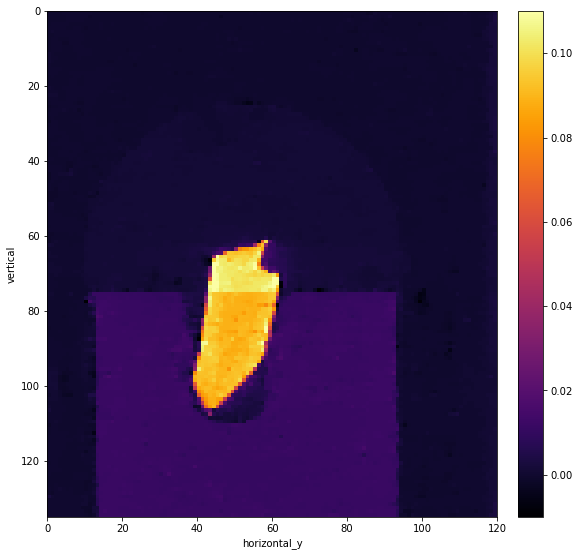

<Figure size 432x288 with 0 Axes>

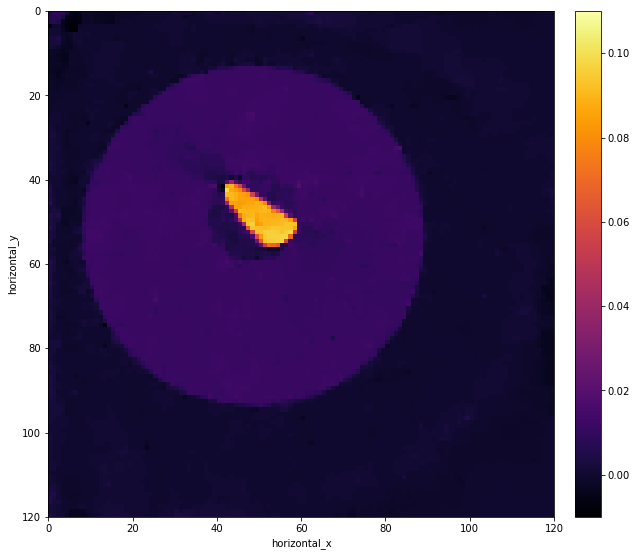

In [29]:
show2D(myPDHG.solution.get_slice(horizontal_x=sx),cmap='inferno',fix_range=(ca1,ca2),origin='upper-left')
show2D(myPDHG.solution.get_slice(vertical=sz),cmap='inferno',fix_range=(ca1,ca2),origin='upper-left')

CIL Algorithms can record history of objective values (primal and dual for PDHG) for monitoring convergence:

Text(0, 0.5, 'Objective value')

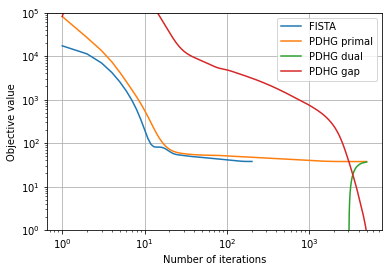

In [38]:
plt.figure()
plt.loglog(myFISTATV.iterations[1:],  myFISTATV.objective[1:])
plt.loglog(myPDHG.iterations[1:],myPDHG.objective[1:])
plt.loglog(myPDHG.iterations[1:],myPDHG.dual_objective[1:])
plt.loglog(myPDHG.iterations[1:],np.array(myPDHG.objective[1:])-np.array(myPDHG.dual_objective[1:]))
plt.ylim((1e0,1e5))
plt.legend(['FISTA','PDHG primal','PDHG dual','PDHG gap'])
plt.grid()
plt.xlabel('Number of iterations')
plt.ylabel('Objective value')